In [1]:
# !pip install keras==2.10 -q
# # # !pip install tensorflow==2.10 -q
# !pip install segmentation-models -q

In [1]:
import tensorflow as tf
from tensorflow import keras
import segmentation_models as sm
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import keras
from keras.utils import normalize
from keras.metrics import MeanIoU

Segmentation Models: using `keras` framework.


In [2]:
#Resizing images, if needed
SIZE_X = 448
SIZE_Y = 448
n_classes=10 #Number of classes for segmentation

#Capture training image info as a list
train_images = []

for directory_path in glob.glob("C:/Users/KIIT/OneDrive/Desktop/Vedant_Official/vedant projects and works/Datasets/Organ_segmentation_dataset/abdominal_US/abdominal_US/AUS/images/train/"):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, 1)
        img = cv2.resize(img, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)
        train_images.append(img)

#Convert list to array for machine learning processing
train_images = np.array(train_images)

#Capture mask/label info as a list
train_masks = []
for directory_path in glob.glob("C:/Users/KIIT/OneDrive/Desktop/Vedant_Official/vedant projects and works/Datasets/Organ_segmentation_dataset/abdominal_US/abdominal_US/AUS/annotations/train/"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        train_masks.append(mask)

#Convert list to array for machine learning processing
train_masks = np.array(train_masks)


In [3]:
print((train_images[0].shape))
print(len(train_masks))

(448, 448, 3)
633


In [4]:
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)

c:\Users\KIIT\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [5]:
# import gc
# del train_masks_reshaped
# del train_masks_reshaped_encoded
# gc.collect()

In [6]:
print(train_masks_encoded_original_shape.shape)
n_classes=10

(633, 448, 448)


In [6]:
# train_images = np.expand_dims(train_images, axis=3)
# train_images = normalize(train_images, axis=1)

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)

#Further split training data t a smaller subset for quick testing of models
# X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.5, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled

from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))



test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))


Class values in the dataset are ...  [0 1 2 3 4 5 6 7 8 9]


In [7]:

#Reused parameters in all models

n_classes=10
activation='softmax'

LR = 0.0001
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
# dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.25, 0.25, 0.25, 0.25]))
# focal_loss = sm.losses.CategoricalFocalLoss()
# total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss
total_loss = sm.losses.categorical_focal_dice_loss

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
# metrics = [sm.metrics.IOUScore(threshold=0.5)]
import sys
# for var_name, var in locals().items():
#     print(f"{var_name}: {sys.getsizeof(var)} bytes")

In [11]:
print(n_classes)
print(X_train.shape)
print(y_train_cat.shape)
print(X_test.shape)
print(y_test_cat.shape)
for var_name, var in locals().items():
    if(sys.getsizeof(var)>10000):
        print(f"{var_name}: {sys.getsizeof(var)} bytes")

10
(569, 448, 448, 3)
(569, 448, 448, 10)
(64, 448, 448, 3)
(64, 448, 448, 10)
X_train: 342601888 bytes
X_test: 38535328 bytes
y_train: 913604768 bytes
y_test: 102760608 bytes


In [10]:
import gc
del train_images
del mask
del img
del train_masks
del train_masks_reshaped_encoded
# del X1
# del y1
# del X_do_not_use
# del y_do_not_use
gc.collect()

476

In [12]:
###Model 1
BACKBONE1 = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)

# preprocess input
X_train1 = preprocess_input1(X_train)
X_test1 = preprocess_input1(X_test)
print(X_train1.shape)
print(X_test1.shape)


(569, 448, 448, 3)
(64, 448, 448, 3)


In [13]:

# define model
model1 = sm.Unet(BACKBONE1, encoder_weights='imagenet', classes=n_classes, activation=activation)

# compile keras model with defined optimozer, loss and metrics
model1.compile(optim, total_loss, metrics=metrics)

#model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

# print(model1.summary())


history1=model1.fit(X_train1,
          y_train_cat,
          batch_size=8,
          epochs=50,
          verbose=1,
          validation_data=(X_test1, y_test_cat))


model1.save('res34_backbone_50epochs.hdf5')

Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1237s 16s/step - f1-score: 0.1082 - iou_score: 0.0825 - loss: 0.9181 - val_f1-score: 0.1694 - val_iou_score: 0.1613 - val_loss: 0.9440
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1101s 15s/step - f1-score: 0.3834 - iou_score: 0.3288 - loss: 0.7823 - val_f1-score: 0.2586 - val_iou_score: 0.2260 - val_loss: 0.8773
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 987s 14s/step - f1-score: 0.4026 - iou_score: 0.3514 - loss: 0.7131 - val_f1-score: 0.3348 - val_iou_score: 0.2932 - val_loss: 0.8419
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1190s 17s/step - f1-score: 0.4621 - iou_score: 0.4010 - loss: 0.6473 - val_f1-score: 0.4471 - val_iou_score: 0.3584 - val_loss: 0.7421
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1243s 17s/step - f1-score: 0.5248 - iou_score: 0.4495 - loss: 0.5889 - val_f1-score: 0.4979 - val_iou_score: 0.4364 - val_loss: 0.6978
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1018s 14s/step - f1-score: 0.5747 - iou_score: 0.5006 - loss: 0.5358 - val_f1-score: 0.4772 - val_

In [ ]:
###Model 2

BACKBONE2 = 'inceptionv3'
preprocess_input2 = sm.get_preprocessing(BACKBONE2)

# preprocess input
X_train2 = preprocess_input2(X_train)
X_test2 = preprocess_input2(X_test)

# define model
model2 = sm.Unet(BACKBONE2, encoder_weights='imagenet', classes=n_classes, activation=activation)


# compile keras model with defined optimozer, loss and metrics
model2.compile(optim, total_loss, metrics)
#model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)


print(model2.summary())


history2=model2.fit(X_train2,
          y_train_cat,
          batch_size=8,
          epochs=50,
          verbose=1,
          validation_data=(X_test2, y_test_cat))


model2.save('inceptionv3_backbone_50epochs.hdf5')

In [ ]:
###Model 3

total_loss = sm.losses.categorical_focal_dice_loss
metrics = [sm.metrics.IOUScore(threshold=0.5)]
BACKBONE3 = 'vgg16'
preprocess_input3 = sm.get_preprocessing(BACKBONE3)

# preprocess input
X_train3 = preprocess_input3(X_train)
X_test3 = preprocess_input3(X_test)


# define model
model3 = sm.Unet(BACKBONE3, encoder_weights='imagenet', classes=n_classes, activation=activation)

# compile keras model with defined optimozer, loss and metrics
model3.compile(optim, total_loss, metrics)
#model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)


print(model3.summary())

history3=model3.fit(X_train3, 
          y_train_cat,
          batch_size=8, 
          epochs=50,
          verbose=1,
          validation_data=(X_test3, y_test_cat))


model3.save('vgg19_backbone_50epochs.hdf5')


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, None,      │      1,792 │ input_layer_2[0]… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, None,      │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, None,      │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, None,      │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, None,      │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, None,      │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, None,      │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, None,      │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, None,      │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, None,      │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, None,      │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, None,      │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, None,      │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, None,      │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, None,      │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, None,      │  2,359,808 │ block5_conv1[0][

 Total params: 23,753,578 (90.61 MB)

 Trainable params: 23,749,546 (90.60 MB)

 Non-trainable params: 4,032 (15.75 KB)

None
Epoch 1/50


ValueError: When there is only a single output, the `loss_weights` argument must be a Python float. Received instead: loss_weights=[<segmentation_models.metrics.IOUScore object at 0x00000222AF0952D0>] of type <class 'list'>

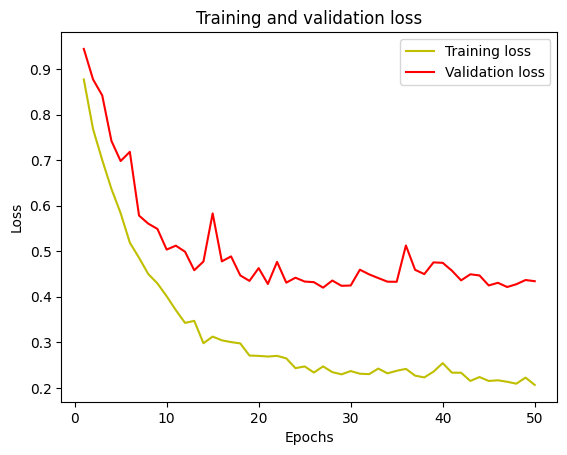

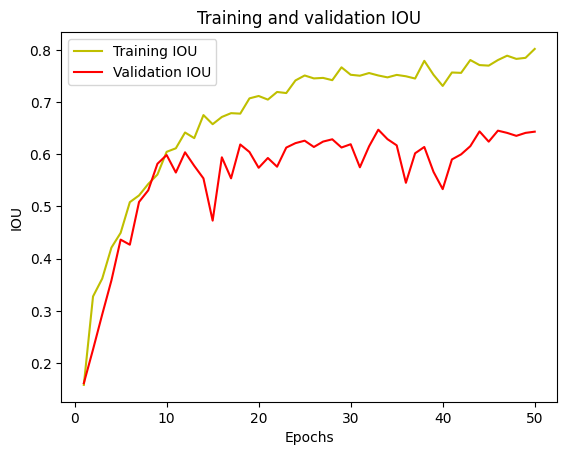

In [14]:
#plot the training and validation accuracy and loss at each epoch
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history1.history['iou_score']
val_acc = history1.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()


In [44]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.metrics import MeanIoU

# Assuming n_classes is the number of classes
n_classes = 10  # Example: 3 classes

# Create some example data
from keras.models import load_model
from keras.metrics import MeanIoU
### FOR NOW LET US FOCUS ON A SINGLE MODEL

#Set compile=False as we are not loading it for training, only for prediction.
model1 = load_model('res34_backbone_50epochs.hdf5', compile=False)
# model2 = load_model('saved_models/inceptionv3_backbone_50epochs.hdf5', compile=False)
# model3 = load_model('saved_models/vgg19_backbone_50epochs.hdf5', compile=False)

#IOU
y_pred1=model1.predict(X_test1)
y_pred1_argmax=np.argmax(y_pred1, axis=3)
# print(y_pred1_argmax)

# Create and update the MeanIoU metric
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test[:,:,:,0], y_pred1_argmax)

# Access the confusion matrix
confusion_matrix = IOU_keras.total_cm.numpy()

# Calculate IoU for each class
iou_per_class = []
for i in range(n_classes):
    true_positives = confusion_matrix[i, i]
    false_positives = np.sum(confusion_matrix[:, i]) - true_positives
    false_negatives = np.sum(confusion_matrix[i, :]) - true_positives
    denominator = true_positives + false_positives + false_negatives
    if denominator == 0:
        iou = 0.0
    else:
        iou = true_positives / denominator
    iou_per_class.append(iou)

iou_per_class = np.array(iou_per_class)
print("IoU per class:")
print(iou_per_class)


2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 10s/step
IoU per class:
[0.93989277 0.99986833 0.12842235 0.8851896  0.61670715 0.4238947
 0.89149284 0.         0.6783811  0.40901127]


In [16]:


#Vaerify the prediction on first image
plt.imshow(train_images[0, :,:,0], cmap='gray')
plt.imshow(train_masks[0], cmap='gray')
##############################################################



NameError: name 'train_images' is not defined

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


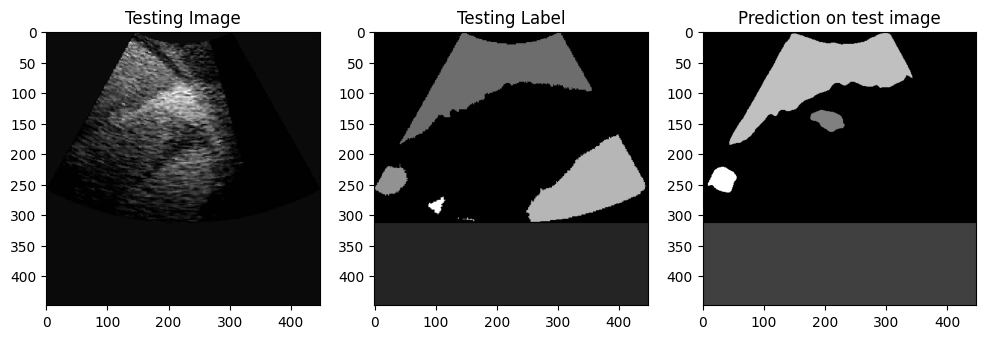

In [57]:
# Test some random images
import random
test_img_number = random.randint(0, len(X_test1))
test_img = X_test1[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input1 = preprocess_input1(test_img_input)

test_pred1 = model1.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1, cmap='gray')
plt.show()

In [42]:
print(X_test.shape)

(64, 448, 448, 3)
